In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
from tqdm import tqdm 
import warnings 
warnings.filterwarnings("ignore")


In [2]:
import os

train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Check if the paths exist
train_exists = os.path.exists(train_path)
test_exists = os.path.exists(test_path)

print("Train path exists:", train_exists)
print("Test path exists:", test_exists)


Train path exists: True
Test path exists: True


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.optimizers.schedules as schedules
from tensorflow.keras.layers import Conv2D,MaxPooling2D , Activation , Dense , Flatten , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint
from glob import glob


In [4]:
x_data = []
y_data = []
for category in glob(train_path+"/*"):
    for file in tqdm(glob(category+"/*")):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split('/')[-1])

data = pd.DataFrame({'image': x_data , "label":y_data})

100%|██████████| 12565/12565 [01:20<00:00, 157.02it/s]


In [5]:
data.shape

(22564, 2)

In [6]:
print(data.columns)
print(type(data))
print(data.info())
print(data.isnull().sum())

Index(['image', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB
None
image    0
label    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

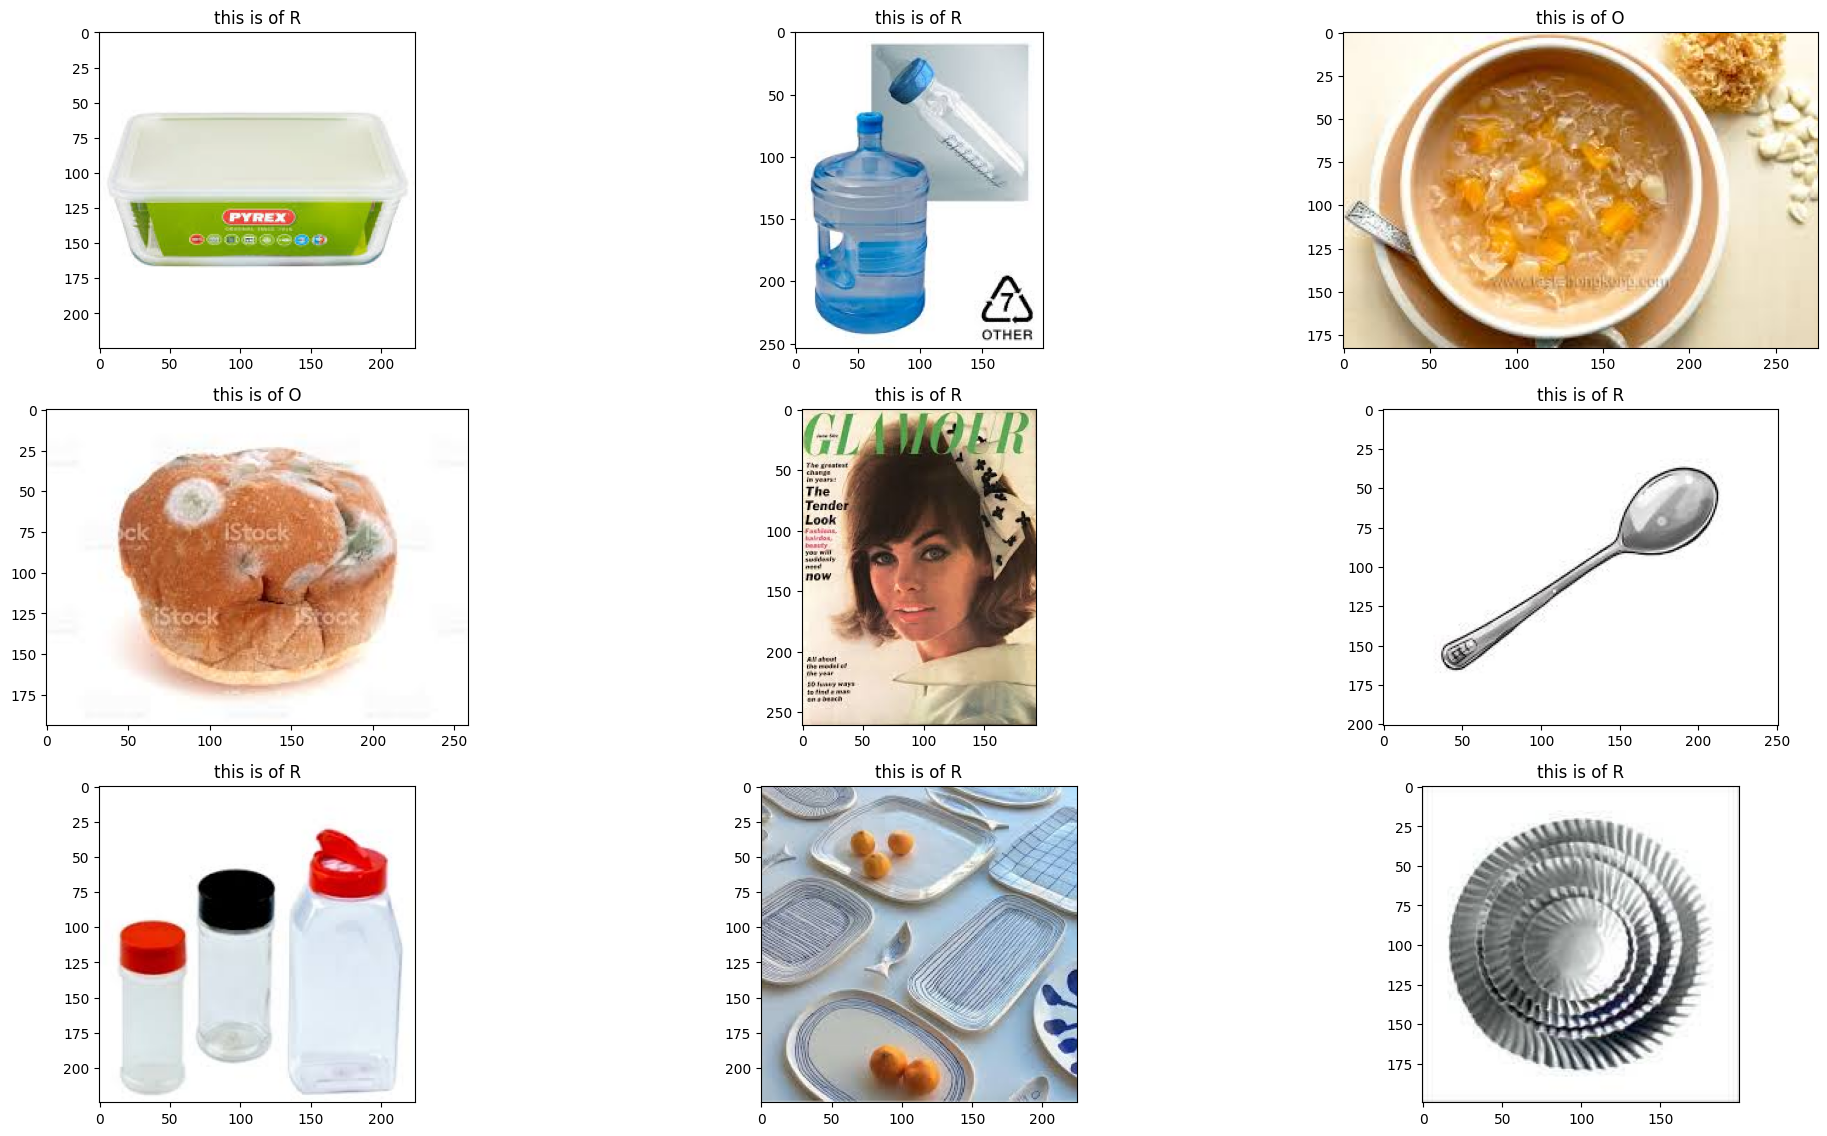

In [7]:
import matplotlib.pyplot as plt 

# Displaying 5 images to inspect dataset
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title("this is of {0}".format(data.label[index]))
    plt.imshow(data.image[index])
    

plt.tight_layout()

plt.show


In [8]:
dimensions = data['image'].apply(lambda img: img.shape)
print(dimensions.value_counts())

image
(225, 225, 3)    4240
(183, 275, 3)    2563
(194, 259, 3)    1728
(168, 300, 3)     943
(275, 183, 3)     497
                 ... 
(152, 225, 3)       1
(300, 153, 3)       1
(299, 154, 3)       1
(219, 166, 3)       1
(220, 217, 3)       1
Name: count, Length: 812, dtype: int64


In [9]:
## trying to find any corrupt or null images in the dataset
missing_images = data['image'].isnull().sum()
print(f"number of missing images : {missing_images}")

corrupt_images = data['image'].apply(lambda img: img.size==0).sum()
print(f" number of corrupt files : {corrupt_images}")

number of missing images : 0
 number of corrupt files : 0


In [10]:

datagen = ImageDataGenerator(rescale = 1./255,
                            rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode = 'nearest',
                            validation_split=0.2)


In [11]:
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Conv2D, MaxPooling2D , Flatten , Dropout , Activation
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img
from tensorflow.keras.utils import plot_model
from glob import glob


In [12]:
## image generators definations 
## for image generations and rescaling b/w 0-255
train_generator = datagen.flow_from_directory(
    train_path,
    target_size = (150,150),
    batch_size = 32,
    subset = 'training',
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [13]:
# model archetecture code
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(150,150,3)),Activation('relu'))

model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3)),Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3)),Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512),Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(train_generator.class_indices)),Activation('softmax'))



optimizer= Adam(learning_rate=0.0001)
model.compile(loss= "categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])



In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,586 (72.61 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


In [16]:
# model check points
checkpoint = ModelCheckpoint("best_model.keras",  
                             save_best_only=True, 
                             )

In [17]:

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
hist = model.fit(
    train_generator,
    epochs=50,
    validation_data = validation_generator,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 141s 235ms/step - accuracy: 0.4862 - loss: 1.4805 - val_accuracy: 0.6746 - val_loss: 1.0475
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 225ms/step - accuracy: 0.6330 - loss: 1.0031 - val_accuracy: 0.6915 - val_loss: 0.8672
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 133s 234ms/step - accuracy: 0.6950 - loss: 0.8664 - val_accuracy: 0.7185 - val_loss: 0.8373
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 134s 234ms/step - accuracy: 0.6742 - loss: 0.8246 - val_accuracy: 0.6709 - val_loss: 0.7902
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 135s 238ms/step - accuracy: 0.6568 - loss: 0.8503 - val_accuracy: 0.6474 - val_loss: 0.7861
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 127s 222ms/step - accuracy: 0.6666 - loss: 0.8167 - val_accuracy: 0.6053 - val_loss: 0.9057
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 127s 222ms/step - accuracy: 0.4887 - loss: 0.9661 - val_accuracy: 0.3480 - val_loss: 1.0450
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 126s 220ms/step - accuracy: 0.3586 -

In [26]:
model.save("Waste-Classification-CNN-Model.h5")

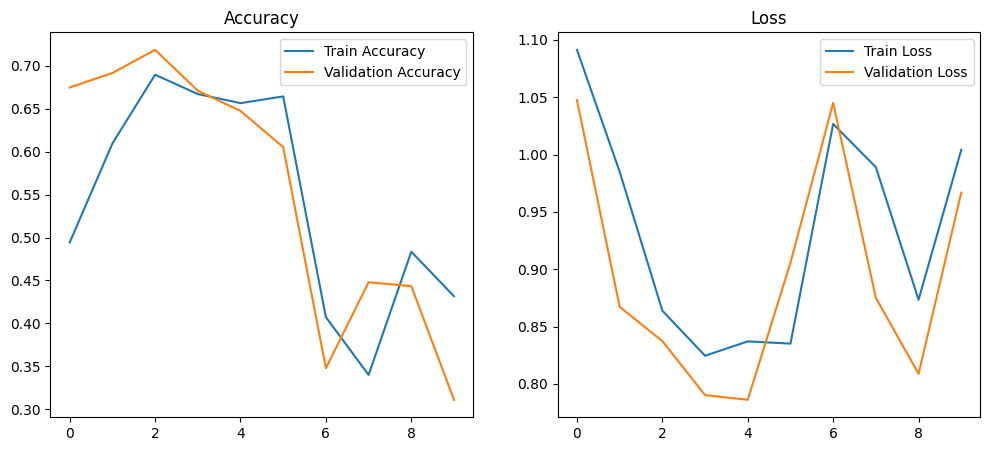

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [20]:
from tensorflow.keras.models import load_model


model = load_model("Waste-Classification-CNN-Model.h5")


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,588 (72.62 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [21]:

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)

Found 2513 images belonging to 2 classes.


In [22]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 0.7915 - loss: 0.7192
Test Accuracy: 74.33%
Test Loss: 0.7955


In [23]:
import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'R', 'R', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


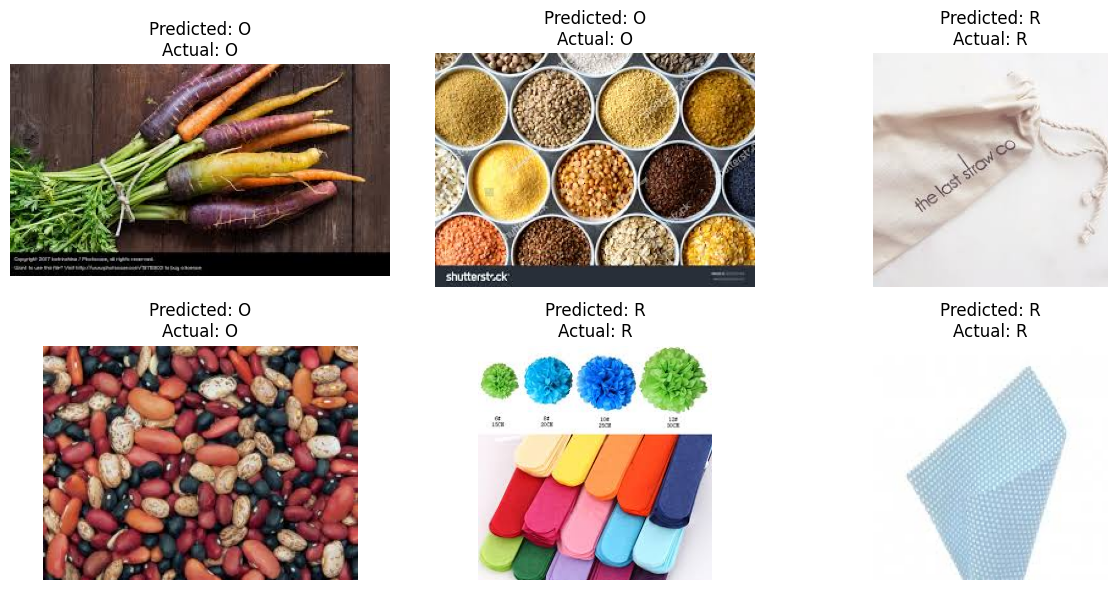

In [27]:
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           O       0.74      0.82      0.78      1401
           R       0.74      0.64      0.69      1112

    accuracy                           0.74      2513
   macro avg       0.74      0.73      0.74      2513
weighted avg       0.74      0.74      0.74      2513



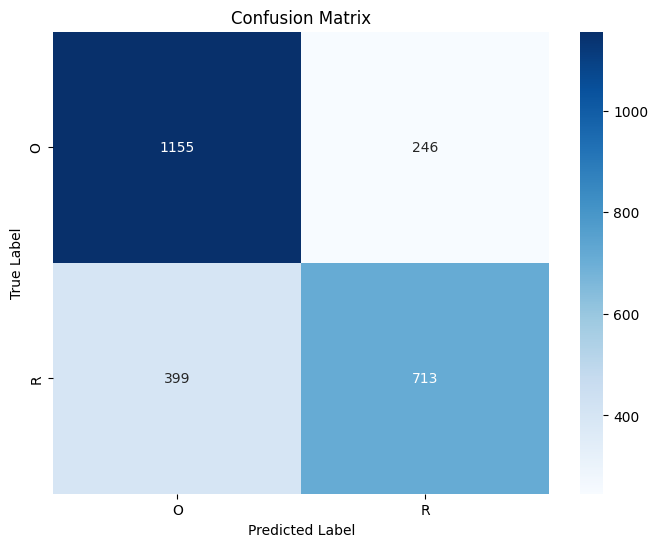

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()